In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

<h1 align="center">Método de Paganin: Tubo 1 - Todas las muestras</h1>

## Delta y Beta para materiales a energia 7.88 keV
```python

deltaPVC=4.86614272E-06
betaPVC = 1.11006727E-07
deltaAgua = 3.67657117E-06
betaAgua = 1.29107205E-08
deltaAire=4.28039426E-09
betaAire=1.17440589E-11
deltaSangreArtificial=6.00424619E-06
betaSangreArtificial=3.11726325E-08
deltaYodo=1.35432474E-05
betaYodo=1.82601411E-06
```


In [2]:
deltaPVC=4.86614272E-06
betaPVC = 1.11006727E-07
deltaAgua = 3.67657117E-06
betaAgua = 1.29107205E-08
deltaAire=4.28039426E-09
betaAire=1.17440589E-11
deltaSangreArtificial=6.00424619E-06
betaSangreArtificial=3.11726325E-08
deltaYodo=1.35432474E-05
betaYodo=1.82601411E-06

In [3]:
def Raws(name):
    RAW = np.rot90(np.genfromtxt(name),1)
    s = np.zeros((len(RAW),len(RAW[0])))
    for i in range(len(RAW)):
        for j in range(len(RAW)):
            if np.isnan(RAW[i,j]):
                RAW[i,j] = 0.0
    for i in range(len(RAW)):
        for j in range(len(RAW[0])):
            if RAW[i,j] == 0.0:
                a = i
                b = j
                c = 0
                suma = 0
                borde = 0
                for k in range(a-1, a+2):
                    for n in range(b-1, b+2):   
                        try:
                            suma += RAW[k,n]
                            if RAW[k,n] == 0.0:
                                c = c + 1
                        except:
                            borde = 1

                if borde == 0:
                    RAW[i,j] = suma/(9-c)
                else:
                    RAW[i,j] = suma/(6-c)
    return RAW

In [4]:
def FF(name, numArchivos):
    FF=[]
    for j in range(numArchivos):
        if j<10:
            FF.append(np.genfromtxt("{}_0{}.txt".format(name,j)))
        if j>=10 and j<numArchivos:
            FF.append(np.genfromtxt("{}_{}.txt".format(name,j)))
    FFmean=np.zeros((len(FF[0]), len(FF[0])))
    for j in range(len(FF)):
        FFmean=FFmean+FF[j]
    FFmean=np.rot90(FFmean,3)
    s = np.zeros((len(FFmean),len(FFmean[0])))
    for i in range(len(FFmean)):
        for j in range(len(FFmean)):
            if np.isnan(FFmean[i,j]):
                FFmean[i,j] = 0.0
    for i in range(len(FFmean)):
        for j in range(len(FFmean[0])):
            if FFmean[i,j] == 0.0:
                a = i
                b = j
                c = 0
                suma = 0
                borde = 0
                for k in range(a-1, a+2):
                    for n in range(b-1, b+2):   
                        try:
                            suma += FFmean[k,n]
                            if FFmean[k,n] == 0.0:
                                c = c + 1
                        except:
                            borde = 1

                if borde == 0:
                    FFmean[i,j] = suma/(9-c)
                else:
                    FFmean[i,j] = suma/(6-c)
    return FFmean

In [5]:
def RawsC(name1, name2, numArchivos, Magn):
    RAWC=(Raws(name1)/FF(name2, numArchivos))*(Magn**2)
    return RAWC

In [6]:
def PhaseR(name1, name2, numArchivos, Npixeles, Magn, a, Gamma, E, z):
    frr = np.fft.fft2(RawsC(name1, name2, numArchivos, Magn))
    frr = np.fft.fftshift(frr)
    frr_abs = np.abs(frr)
    array_dist=np.zeros((Npixeles,Npixeles))
    for i in range(0,Npixeles):
        for j in range(0, Npixeles):
            r=((2*np.pi*((Npixeles/2)-i))/(Npixeles*a))**2+((2*np.pi*((Npixeles/2)-j))/(Npixeles*a))**2
            array_dist[i,j]=r
    E_J=E*1.6*(10**(-16))
    h=10**(-34)
    c=3*(10**(8))
    k=E_J/(h*c)
    # W=(delta*z)/(2*beta*k)
    W=(Gamma*z)/(Magn*k)
    AA=np.ones((Npixeles,Npixeles))
    Q=AA+W*array_dist
    A=frr/Q
    f_ishift = np.fft.ifftshift(A)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

In [7]:
def Phase(name1, name2, numArchivos, Npixeles, Magn, a, Gamma, E, z):
    Ps=(Gamma/2)*np.log(PhaseR(name1, name2, numArchivos, Npixeles, Magn, a, Gamma, E, z))
    return Ps

### Sangre artificial:

In [8]:
name1 = "./datos/2022-09-02 - Muestra de Sangre Artificial/1. RAW_tubo1_sangre/RAW.txt"
name2 = "./datos/2022-09-02 - Muestra de Sangre Artificial/2. FF/FF"
M=3
Gamma = deltaSangreArtificial/(2*betaSangreArtificial) #67.41977862   
P=256
a=5.5*(10**(-5))
E=28
z=1.2

In [9]:
RAW_sangre=RawsC(name1, name2, 59, M)
I_sangre=PhaseR(name1, name2, 59, P, M, a, Gamma, E, z)
Phi_sangre=Phase(name1, name2, 59, P, M, a, Gamma, E, z)
FF_sangre= FF(name2, 59)

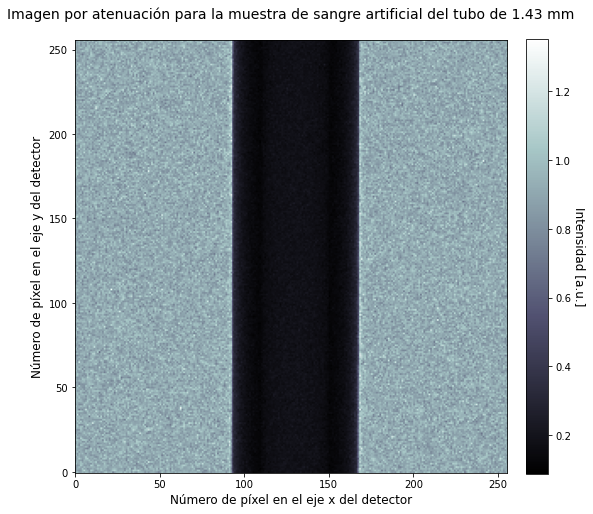

In [10]:
# Imagen de absorcion 
plt.figure(figsize=(8,8))
im = plt.imshow(abs(RAW_sangre), cmap="bone")
plt.gca().invert_yaxis()
plt.title('Imagen por atenuación para la muestra de sangre artificial del tubo de 1.43 mm\n', fontsize=14)
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Atenuacion/SangreArtificial.pdf')

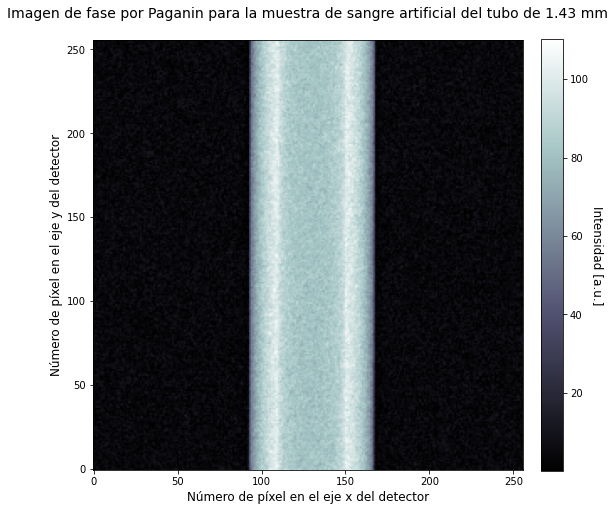

In [11]:
plt.figure(figsize=(8,8))
im = plt.imshow(abs(Phi_sangre), cmap="bone")
plt.title('Imagen de fase por Paganin para la muestra de sangre artificial del tubo de 1.43 mm\n', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Fase/SangreArtificial.pdf')

### Tubo de aire

In [12]:
name1 = "./datos/2022-09-02 - Muestra de Aire/1. RAW_tubo1_sangre/RAW.txt"
name2 = "./datos/2022-09-02 - Muestra de Aire/2. FF/FF"
M=3
Gamma = deltaAire/(2*betaAire)   
P=256
a=5.5*(10**(-5))
E=28
z=1.2

In [13]:
RAW_aire=RawsC(name1, name2, 59, M)
I_aire=PhaseR(name1, name2, 59, P, M, a, Gamma, E, z)
Phi_aire=Phase(name1, name2, 59, P, M, a, Gamma, E, z)

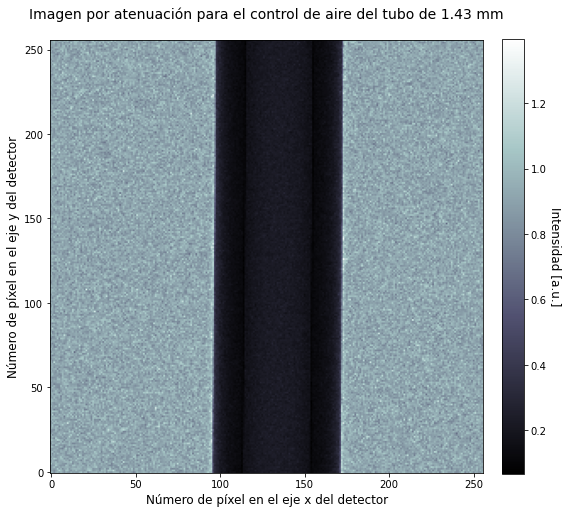

In [14]:
# Imagen de absorcion 
plt.figure(figsize=(8,8))
im = plt.imshow(abs(RAW_aire), cmap="bone")
plt.title('Imagen por atenuación para el control de aire del tubo de 1.43 mm\n', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Atenuacion/Aire.pdf')

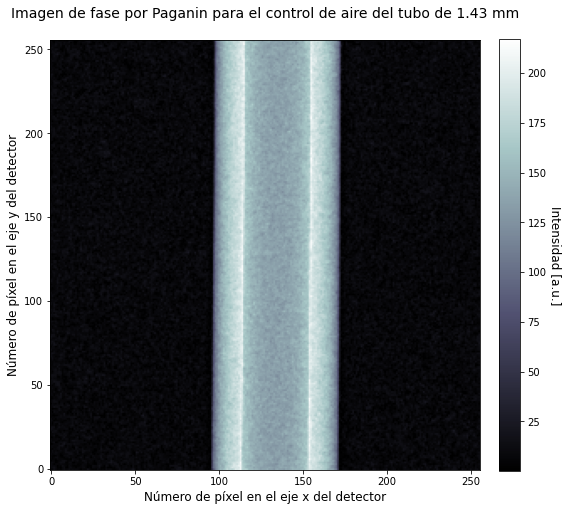

In [15]:
plt.figure(figsize=(8,8))
im = plt.imshow(abs(Phi_aire), cmap="bone")
plt.title('Imagen de fase por Paganin para el control de aire del tubo de 1.43 mm\n', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Fase/Aire.pdf')

### Tubo de agua

In [16]:
name1 = "./datos/2022-09-20 - Muestra de Agua/1. RAW_tubo3_sangre/RAW.txt"
name2 = "./datos/2022-09-20 - Muestra de Agua/2. FF/FF"
M=3
Gamma = deltaAgua/(2*betaAgua)   
P=256
a=5.5*(10**(-5))
E=28
z=1.2

In [17]:
RAW_agua=RawsC(name1, name2, 59, M)
I_agua=PhaseR(name1, name2, 59, P, M, a, Gamma, E, z)
Phi_agua=Phase(name1, name2, 59, P, M, a, Gamma, E, z)

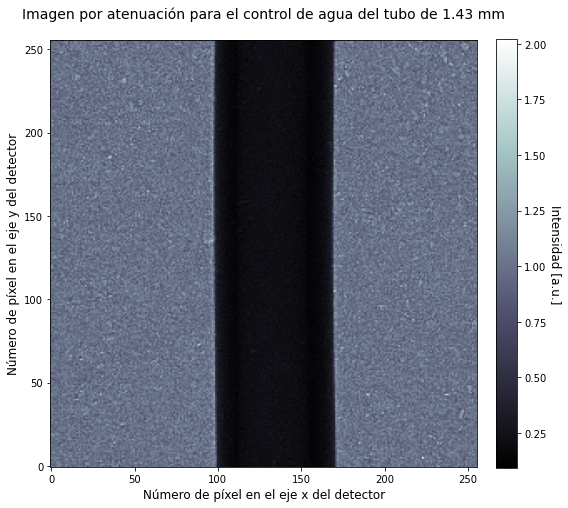

In [18]:
# Imagen de absorcion 
plt.figure(figsize=(8,8))
im = plt.imshow(abs(RAW_agua), cmap="bone")
plt.title('Imagen por atenuación para el control de agua del tubo de 1.43 mm\n', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Atenuacion/Agua.pdf')

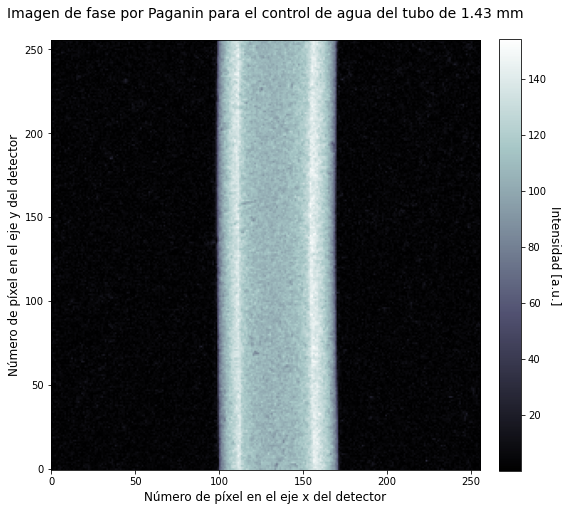

In [19]:
plt.figure(figsize=(8,8))
im = plt.imshow(abs(Phi_agua), cmap="bone")
plt.title('Imagen de fase por Paganin para el control de agua del tubo de 1.43 mm\n', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Fase/Agua.pdf')

### Tubo de yodopovidona

In [20]:
name1 = "./datos/2022-09-02 - Muestra de Yodopovidona/1. RAW_tubo1_sangre/RAW.txt"
name2 = "./datos/2022-09-02 - Muestra de Yodopovidona/2. FF/FF"
M=3
Gamma = deltaYodo/(2*betaYodo)   
P=256
a=5.5*(10**(-5))
E=28
z=1.2

In [21]:
RAW_yodo=RawsC(name1, name2, 59, M)
I_yodo=PhaseR(name1, name2, 59, P, M, a, Gamma, E, z)
Phi_yodo=Phase(name1, name2, 59, P, M, a, Gamma, E, z)

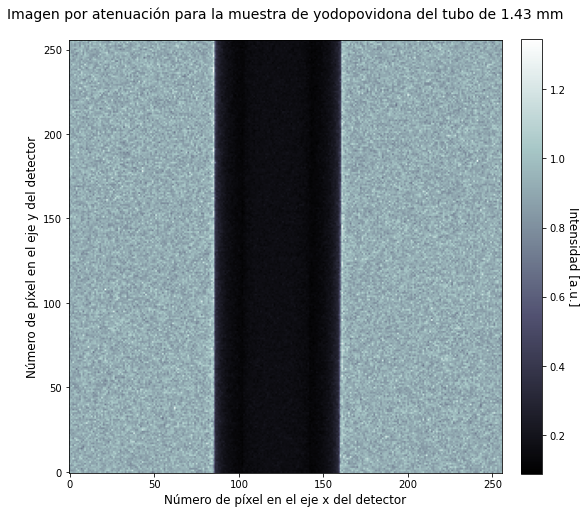

In [22]:
# Imagen de absorcion 
plt.figure(figsize=(8,8))
im = plt.imshow(abs(RAW_yodo), cmap="bone")
plt.title('Imagen por atenuación para la muestra de yodopovidona del tubo de 1.43 mm\n', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Atenuacion/Yodopovidona.pdf')

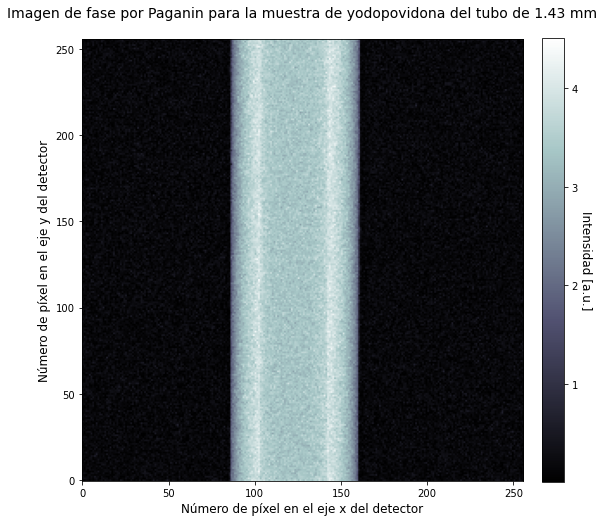

In [23]:
plt.figure(figsize=(8,8))
im = plt.imshow(abs(Phi_yodo), cmap="bone")
plt.title('Imagen de fase por Paganin para la muestra de yodopovidona del tubo de 1.43 mm\n', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Número de píxel en el eje x del detector', fontsize=12)
plt.ylabel('Número de píxel en el eje y del detector', fontsize=12)
clb = plt.colorbar(im,fraction=0.046, pad=0.04)
clb.ax.get_yaxis().labelpad = 15
clb.set_label('Intensidad [a.u.]', rotation=270, fontsize=12)
plt.tight_layout()
plt.savefig('Paganin-Tubo1-Imagenes/Fase/Yodopovidona.pdf')

In [24]:
# Poner todos los perfiles juntos aqui 
# Comparar los resultados con Ankaphase
# Calcular CNR (contrast to noise ratio) ? O dejarlo para la ultima entrega

In [25]:
def normalized_average(Phi):
    return np.abs(np.mean(Phi, axis=0)/np.linalg.norm(np.mean(Phi, axis=0)))

In [26]:
pp_sangre = normalized_average(Phi_sangre) 
pp_aire = normalized_average(Phi_aire) 
pp_agua = normalized_average(Phi_agua) 
pp_yodo = normalized_average(Phi_yodo) 

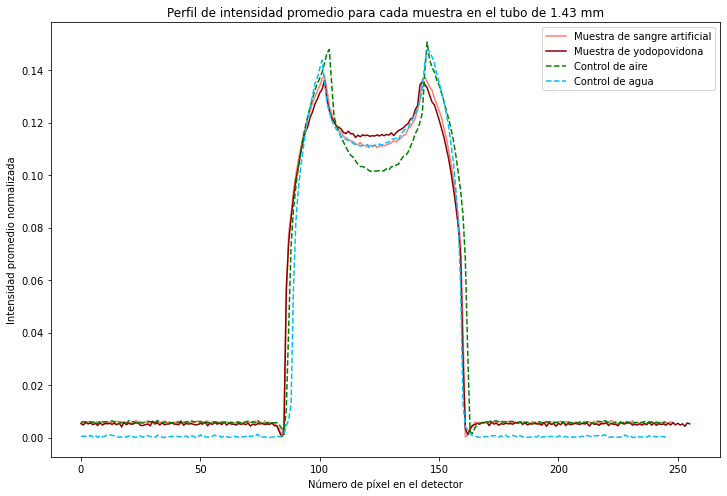

In [27]:
plt.figure(figsize=(12,8))
plt.plot(pp_sangre[7:], label="Muestra de sangre artificial",  c="salmon")
plt.plot(pp_yodo[:], label="Muestra de yodopovidona",  c="darkred")
plt.plot(pp_aire[10:], '--', label="Control de aire", c="green")
plt.plot(pp_agua[10:], '--', label="Control de agua", c="deepskyblue")
plt.title("Perfil de intensidad promedio para cada muestra en el tubo de 1.43 mm")
plt.ylabel("Intensidad promedio normalizada")
plt.legend()
plt.xlabel("Número de píxel en el detector")
plt.savefig('Paganin-Tubo1-Imagenes/todos_perfiles.pdf')

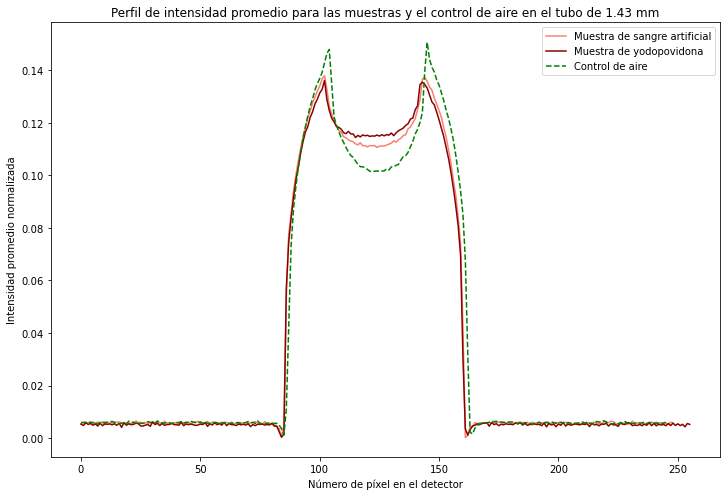

In [28]:
plt.figure(figsize=(12,8))
plt.plot(pp_sangre[7:], label="Muestra de sangre artificial", c="salmon")
plt.plot(pp_yodo[:], label="Muestra de yodopovidona", c="darkred")
plt.plot(pp_aire[10:], '--', label="Control de aire", c="green")
plt.title("Perfil de intensidad promedio para las muestras y el control de aire en el tubo de 1.43 mm")
plt.ylabel("Intensidad promedio normalizada")
plt.legend()
plt.xlabel("Número de píxel en el detector")
plt.savefig('Paganin-Tubo1-Imagenes/muestras_aire.pdf')

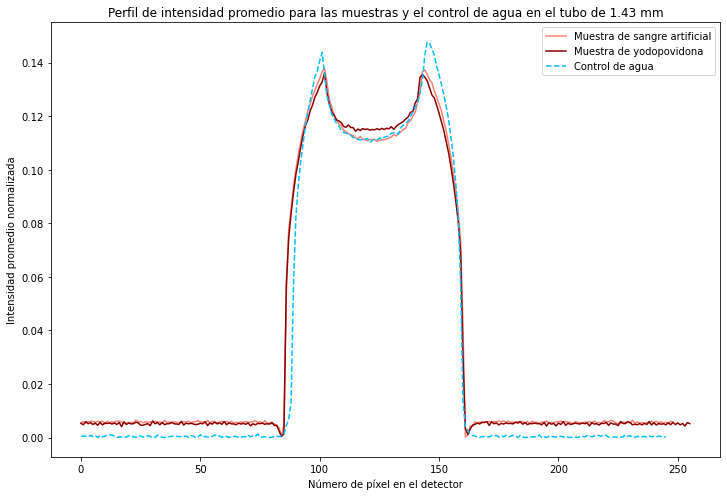

In [29]:
plt.figure(figsize=(12,8))
plt.plot(pp_sangre[7:], label="Muestra de sangre artificial", c="salmon")
plt.plot(pp_yodo[:], label="Muestra de yodopovidona", c="darkred")
plt.plot(pp_agua[10:], '--', label="Control de agua", c="deepskyblue")
plt.title("Perfil de intensidad promedio para las muestras y el control de agua en el tubo de 1.43 mm")
plt.ylabel("Intensidad promedio normalizada")
plt.legend()
plt.xlabel("Número de píxel en el detector")
plt.savefig('Paganin-Tubo1-Imagenes/muestras_agua.pdf')

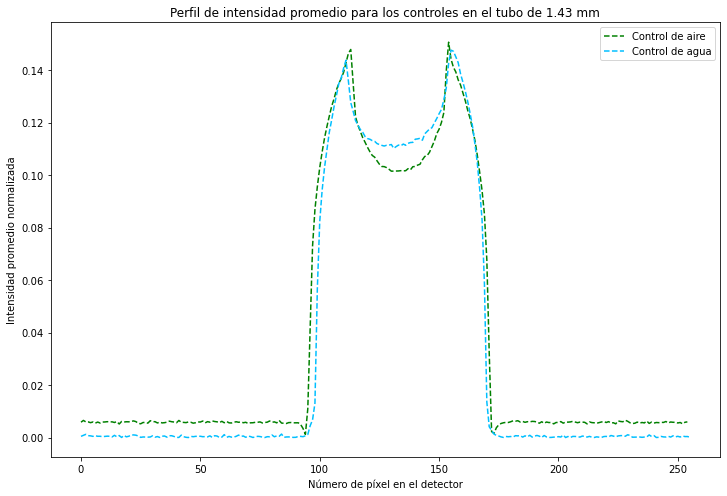

In [30]:
plt.figure(figsize=(12,8))
plt.plot(pp_aire[1:], '--', label="Control de aire", c="green")
plt.plot(pp_agua[:], '--', label="Control de agua", c="deepskyblue")
plt.title("Perfil de intensidad promedio para los controles en el tubo de 1.43 mm")
plt.ylabel("Intensidad promedio normalizada")
plt.legend()
plt.xlabel("Número de píxel en el detector")
plt.savefig('Paganin-Tubo1-Imagenes/controles.pdf')